In [26]:
import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.model import ConvNP
from deepsensor.train import Trainer

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import notebook
from deepsensor.train import set_gpu_default_device
from xarray.groupers import TimeResampler

import torch

import subprocess
import time

def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]
    for task in val_tasks:
        #mean = torch.tensor(data_processor.map_array(model.mean(task), target_var_ID, unnorm=True), device=device)
        #true = torch.tensor(data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True), device=device)
        #errors.extend(torch.abs(mean - true).cpu().numpy())  # Convert back to NumPy if needed
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

    
def gen_tasks(dates, progress=True):
    tasks = []
    for date in notebook.tqdm(dates, disable=not progress):
        N_c = np.random.randint(0, 500)
        task = task_loader(date, context_sampling=[N_c, "all", "all", N_c], target_sampling="all")
        tasks.append(task)
    return tasks

def gen_tasks_lake(dates, lake_indices, progress=True):
    tasks = []
    for date in notebook.tqdm(dates, disable=not progress):
        N_c = np.random.randint(0, 500)
        chosen_idxs = lake_indices[np.random.choice(len(lake_indices), N_c, replace=False)]
        coords = [tuple(idx) for idx in chosen_idxs]  # (lat_idx, lon_idx)
        task = task_loader(date, context_sampling=[coords, "all", "all", N_c], target_sampling="all")
        tasks.append(task)
    return tasks



def transform_ice(da):
    da = xr.DataArray(da)  # Ensure input is always an xarray.DataArray
    nan_mask = da.isnull()  # This correctly creates a mask in xarray
    transformed = xr.where(da > 0.2, 0, 1)  # Apply thresholding
    transformed = transformed.where(~nan_mask, np.nan)  # Preserve NaNs
    return transformed

def get_gpu_usage():
    try:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,noheader,nounits"],
            stdout=subprocess.PIPE,
            text=True
        )
        return int(result.stdout.strip())  # Extract GPU usage as integer
    except Exception as e:
        print(f"Error fetching GPU usage: {e}")
        return None

# Track GPU usage at different checkpoints
timestamps = []
gpu_usages = []
checkpoints = ["Start", "Epoch_1", "Epoch_2", "Epoch_3", "Epoch_5", "Epoch_5", "End"]

# Example script sections
timestamps.append("Start")
gpu_usages.append(get_gpu_usage())

set_gpu_default_device()
scratch_path = "/scratch/dannes_root/dannes0/saiavu"

output_file = open("output.txt", "w")

start_year = 2007
end_year = 2023
start_dt = str(start_year) + "-01-01T12:00:00.000000000"
end_dt = str(end_year) + "-12-31T12:00:00.000000000"

bathymetry_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/bathymetry/interpolated_bathymetry.nc'
mask_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/masks/lakemask.nc'

mask = xr.open_dataset(mask_path)#, chunks = "auto")
bath = xr.open_dataset(bathymetry_path)#, chunks = "auto")


fpath = [f'/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_NETCDF/GLSEA3_{date}.nc' for date in range(start_year, end_year+1)]

# Load dataset using xarray with chunking
glsea3_raw = xr.open_mfdataset(
    fpath, combine="by_coords", chunks={"time": 3, "lat": 512, "lon": 512}
).drop_vars('crs', errors="ignore")


# Apply transform_ice function while keeping it as xarray
ice_mask = xr.apply_ufunc(
    transform_ice,
    glsea3_raw["sst"],  # Ensure function applies only to 'sst' DataArray
    dask="allowed",  # Ensures correct Dask processing
    output_dtypes=[glsea3_raw["sst"].dtype],
    keep_attrs=True,  # Preserve metadata
)

ice_mask = ice_mask.rename("binary_ice_indicator")

#glsea3_new = xr.apply_ufunc(transform_nan, glsea3_raw, dask="allowed", output_dtypes=[glsea3_raw["sst"].dtype])
glsea3_new = glsea3_raw.where(np.isnan(glsea3_raw.sst) == False, -0.009) 

climatology = glsea3_new.groupby("time.dayofyear").mean("time")

anomalies = glsea3_new.groupby("time.dayofyear") - climatology

anomalies = anomalies.chunk({"time": 1, "lat": 838, "lon": 1181})
ice_mask = ice_mask.chunk({"time": 1, "lat": 838, "lon": 1181})

#anomalies = anomalies.chunk({"time": "YE"})
#ice_mask = ice_mask.chunk({"time": "YE"})




data_processor = DataProcessor(x1_name="lat", x2_name="lon")

mask_ds = data_processor(mask)

bath_ds = data_processor(bath)

_ = data_processor(anomalies.sel(time = slice("2007-01-01T12:00:00.000000000", "2007-04-01T12:00:00.000000000")))
anom_ds = data_processor(anomalies)

_ = data_processor(ice_mask.sel(time = slice("2007-01-01T12:00:00.000000000", "2007-04-01T12:00:00.000000000")))
ice_ds = data_processor(ice_mask)

data_processor.save(scratch_path + "/deepsensor_config/")

output_file.write("Preprocessing complete!\n")

24

In [19]:
anomalies["sst"]

<xarray.DataArray 'sst' (time: 6205, lat: 838, lon: 1181)> Size: 25GB
dask.array<rechunk-merge, shape=(6205, 838, 1181), dtype=float32, chunksize=(1, 838, 1181), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 50kB 2007-01-01T12:00:00 ... 2023-12-31T...
  * lon        (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * lat        (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
    dayofyear  (time) int64 50kB dask.array<chunksize=(1,), meta=np.ndarray>

In [27]:
task_loader = TaskLoader(
    context = [anom_ds, mask_ds, bath_ds, ice_ds],
    target = anom_ds, 
)

In [35]:
anom_ds["sst"].sel(time = "2008-12-25T12:00:00")

<xarray.DataArray 'sst' (time: 6205, x1: 838, x2: 1181)> Size: 25GB
dask.array<add, shape=(6205, 838, 1181), dtype=float32, chunksize=(1, 838, 1181), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 50kB 2007-01-01T12:00:00 ... 2023-12-31T...
    dayofyear  (time) int64 50kB dask.array<chunksize=(1,), meta=np.ndarray>
  * x1         (x1) float64 7kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
  * x2         (x2) float64 9kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0

In [34]:
N_c = np.random.randint(0, 500)
lake_mask = mask_ds["mask"].values.astype(bool) 
lake_indices = np.argwhere(lake_mask)
chosen_idxs = lake_indices[np.random.choice(len(lake_indices), N_c, replace=False)]
coords = [tuple(idx) for idx in chosen_idxs]  # (lat_idx, lon_idx)
task = task_loader("2007-01-15T12:00:00", context_sampling=[coords, "all", "all", N_c], target_sampling="all")
print(task)

InvalidSamplingStrategyError: Unknown sampling strategy [(542, 999), (159, 1145), (390, 287), (134, 595), (214, 846), (372, 554), (196, 904), (320, 38), (685, 497), (558, 96), (119, 726), (761, 822), (604, 785), (582, 398), (29, 351), (793, 623), (39, 483), (808, 924), (729, 462), (146, 708), (187, 201), (279, 43), (603, 971), (555, 366), (391, 996), (63, 1174), (739, 426), (757, 82), (572, 1102), (574, 123), (80, 329), (127, 1), (322, 111), (481, 1100), (807, 628), (605, 155), (274, 755), (311, 283), (554, 1115), (522, 502), (202, 1023), (488, 211), (200, 209), (230, 685), (520, 902), (207, 1044), (579, 647), (424, 441), (282, 807), (393, 834), (326, 663), (475, 807), (466, 150), (86, 388), (808, 187), (225, 343), (321, 1157), (101, 1048), (601, 1035), (618, 97), (295, 33), (762, 23), (607, 210), (662, 84), (318, 81), (61, 326), (562, 958), (761, 66), (652, 699), (789, 954), (18, 290), (186, 1026), (479, 14), (123, 102), (466, 786), (761, 181), (724, 810), (792, 1156), (709, 222), (776, 812), (99, 743), (603, 991), (399, 90), (9, 560), (593, 1127), (473, 96), (5, 877), (627, 40), (627, 1053), (137, 1176), (553, 347), (100, 623), (649, 558), (191, 575), (407, 9), (659, 1122), (661, 605), (414, 845), (590, 244), (259, 727), (436, 954), (21, 44), (502, 802), (160, 1073), (747, 473), (615, 893), (87, 439), (805, 755)] of type <class 'list'>

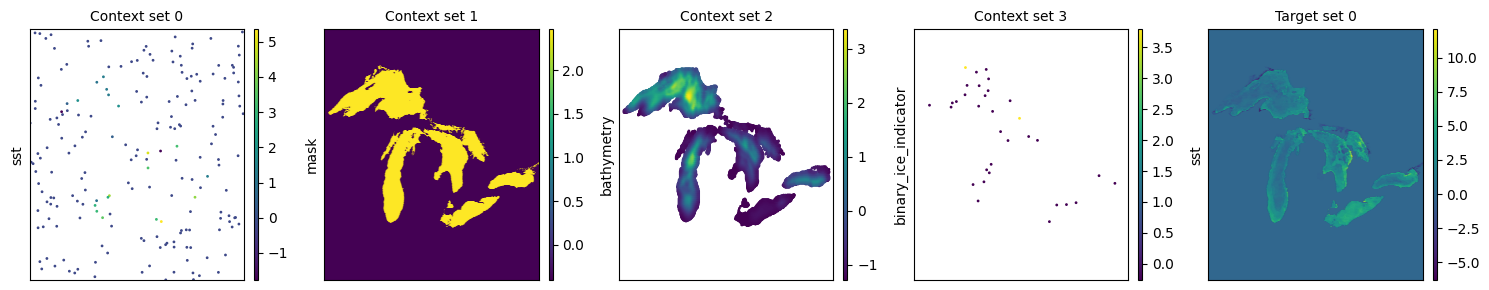

In [29]:
fig = deepsensor.plot.task(task, task_loader)
plt.show()

In [21]:
profile_dates = pd.date_range("2007-01-15T12:00:00", "2007-02-05T12:00:00")
print(profile_dates[::5])

DatetimeIndex(['2007-01-15 12:00:00', '2007-01-20 12:00:00',
               '2007-01-25 12:00:00', '2007-01-30 12:00:00',
               '2007-02-04 12:00:00'],
              dtype='datetime64[ns]', freq='5D')


In [ ]:
import cProfile
cProfile.run('gen_tasks(profile_dates[::5])')

In [22]:
start = time.time()
tasks = gen_tasks(profile_dates[::5])
end = time.time()
print(end-start)

  0%|          | 0/5 [00:00<?, ?it/s]

9.74109411239624


In [23]:
from concurrent.futures import ThreadPoolExecutor

def gen_tasks_parallel(dates, max_workers=4):
    def make_task(date):
        N_c = np.random.randint(0, 500)
        return task_loader(date, context_sampling=[N_c, "all", "all", N_c], target_sampling="all")
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        tasks = list(executor.map(make_task, dates))
    return tasks

In [10]:
import os
print(os.cpu_count())

40


In [24]:
start = time.time()
tasks = gen_tasks_parallel(profile_dates[::5], max_workers = 2)
end = time.time()
print(end-start)

10.76624345779419


In [20]:
tasks

[time: Timestamp/2007-01-15 12:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 20)', ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 240)', 'ndarray/float32/(1, 360)'), 'ndarray/float32/(2, 20)']
 Y_c: ['ndarray/float32/(1, 20)', 'ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 240, 360)', 'ndarray/float32/(1, 20)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_t: ['ndarray/float32/(1, 838, 1181)'],
 time: Timestamp/2007-01-20 12:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 419)', ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 240)', 'ndarray/float32/(1, 360)'), 'ndarray/float32/(2, 419)']
 Y_c: ['ndarray/float32/(1, 419)', 'ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 240, 360)', 'ndarray/float32/(1, 419)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_t: ['ndarray/float32/(1, 838, 1181)'],
 time: Timestamp/2007-01-25 12:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 14

In [22]:
import pickle

with open('tasks.pkl', 'wb') as f:
    pickle.dump(tasks, f)

In [23]:
with open('tasks.pkl', 'rb') as f:
    saved_tasks = pickle.load(f)

In [24]:
saved_tasks

[time: Timestamp/2007-01-15 12:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 20)', ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 240)', 'ndarray/float32/(1, 360)'), 'ndarray/float32/(2, 20)']
 Y_c: ['ndarray/float32/(1, 20)', 'ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 240, 360)', 'ndarray/float32/(1, 20)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_t: ['ndarray/float32/(1, 838, 1181)'],
 time: Timestamp/2007-01-20 12:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 419)', ('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)'), ('ndarray/float32/(1, 240)', 'ndarray/float32/(1, 360)'), 'ndarray/float32/(2, 419)']
 Y_c: ['ndarray/float32/(1, 419)', 'ndarray/float32/(1, 838, 1181)', 'ndarray/float32/(1, 240, 360)', 'ndarray/float32/(1, 419)']
 X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
 Y_t: ['ndarray/float32/(1, 838, 1181)'],
 time: Timestamp/2007-01-25 12:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 14

In [ ]:
import dask

In [6]:
anomalies["sst"]

<xarray.DataArray 'sst' (time: 3652, lat: 838, lon: 1181)> Size: 14GB
dask.array<rechunk-merge, shape=(3652, 838, 1181), dtype=float32, chunksize=(3, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 29kB 2007-01-01T12:00:00 ... 2016-12-31T...
  * lon        (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * lat        (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
    dayofyear  (time) int64 29kB dask.array<chunksize=(3,), meta=np.ndarray>

In [11]:
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]
    for task in val_tasks:
        #mean = torch.tensor(data_processor.map_array(model.mean(task), target_var_ID, unnorm=True), device=device)
        #true = torch.tensor(data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True), device=device)
        #errors.extend(torch.abs(mean - true).cpu().numpy())  # Convert back to NumPy if needed
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [3]:
set_gpu_default_device()


timestamps.append("Start")
gpu_usages.append(get_gpu_usage())


val_dates = pd.date_range(str(end_year-1) + "-01-01T12:00:00.000000000", str(end_year) + "-12-31T12:00:00.000000000")[::5]
val_tasks = gen_tasks(val_dates)
model = ConvNP(data_processor, task_loader)

losses = []
val_rmses = []
train_range = pd.date_range(str(start_year) + "-01-01T12:00:00.000000000", str(end_year-2) + "-12-31T12:00:00.000000000")

 

val_rmse_best = np.inf
trainer = Trainer(model, lr=2e-5)

  0%|          | 0/146 [00:00<?, ?it/s]

dim_yc inferred from TaskLoader: (1, 1, 1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 1180
encoder_scales inferred from TaskLoader: [0.00042372880852781236, 0.00042372880852781236, 0.0009355429210700095, 0.00042372880852781236]
decoder_scale inferred from TaskLoader: 0.000847457627118644


In [5]:
epochs = 25

for epoch in range(epochs):
    train_tasks = gen_tasks(train_range[::5], progress=True)

    batch_losses = trainer(train_tasks, progress_bar = True)
    mean_loss = np.mean(batch_losses)
    losses.append(mean_loss)

    val_rmse = compute_val_rmse(model, val_tasks)
    val_rmses.append(val_rmse)
    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]
        model.save(scratch_path + "/model")
        
    output_file.write("Epoch:\n")
    output_file.write(str(mean_loss) + "\n")
    output_file.write(str(val_rmse) + "\n")

    timestamps.append("Epoch_" + str(epoch))
    gpu_usages.append(get_gpu_usage())

  0%|          | 0/1096 [00:00<?, ?it/s]

100%|██████████| 1096/1096 [15:07<00:00,  1.21it/s]


  0%|          | 0/1096 [00:00<?, ?it/s]

100%|██████████| 1096/1096 [15:07<00:00,  1.21it/s]


  0%|          | 0/1096 [00:00<?, ?it/s]

100%|██████████| 1096/1096 [15:06<00:00,  1.21it/s]


  0%|          | 0/1096 [00:00<?, ?it/s]

100%|██████████| 1096/1096 [15:07<00:00,  1.21it/s]


  0%|          | 0/1096 [00:00<?, ?it/s]

100%|██████████| 1096/1096 [15:06<00:00,  1.21it/s]


  0%|          | 0/1096 [00:00<?, ?it/s]

100%|██████████| 1096/1096 [15:06<00:00,  1.21it/s]


  0%|          | 0/1096 [00:00<?, ?it/s]

KeyboardInterrupt: 

Done!


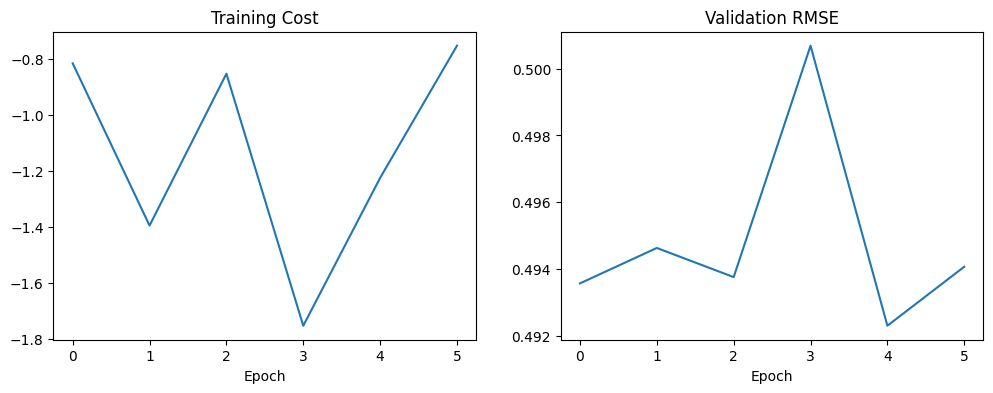

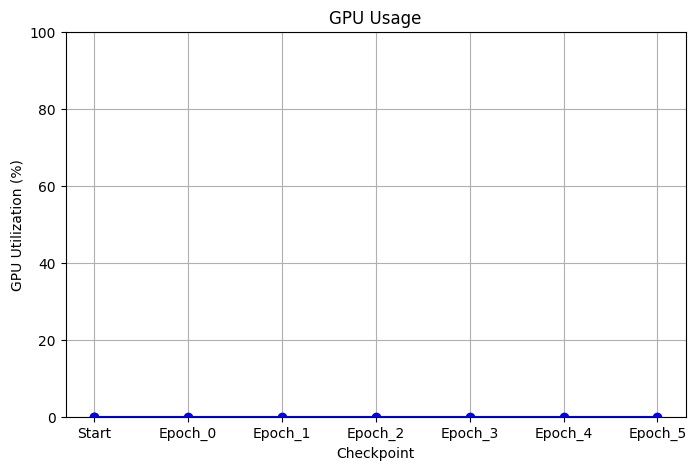

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training Cost")
_ = axes[1].set_title("Validation RMSE")
plt.savefig(scratch_path + 'training_5.png')

# Plot GPU usage
plt.figure(figsize=(8, 5))
plt.plot(timestamps, gpu_usages, marker="o", linestyle="-", color="b")
plt.xlabel("Checkpoint")
plt.ylabel("GPU Utilization (%)")
plt.title("GPU Usage")
plt.ylim(0, 100)
plt.grid(True)
plt.savefig(scratch_path + 'usage.png')

print("Done!")